# Imports

In [1]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import os
import time
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import files
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Will use CPU instead.")

# Set device
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

GPU available: True
Number of GPUs: 1
GPU 0: Tesla T4
Using device: 0


# Dataset Download Section

In [4]:
rf = Roboflow(api_key="OOMi0m3PhpE0bSmlr5rx")
project = rf.workspace("luigui-andre-cerna-grados-dpsrr").project("clasificacion-de-mangos")
version = project.version(16)

# Retry mechanism with error handling
retries = 3
for attempt in range(retries):
    try:
        dataset = version.download("yolov12")
        break  # Exit loop if successful
    except ConnectionError as e:
        print(f"Download attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print(f"Retrying in 5 seconds...")
            time.sleep(5)  # Wait before retrying
        else:
            print("Maximum retries reached. Download failed.")
            raise  # Re-raise the exception after max retries

# Rename the dataset folder to a more manageable name
!mv "/content/Clasificación-de-mangos-16" "/content/mango_dataset"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Clasificación-de-mangos-16 in yolov12:: 100%|██████████| 4004/4004 [00:00<00:00, 4416.80it/s]


# Data Preprocessing Section

Starting dataset preprocessing...
Training set: 1529 images
Validation set: 65 images


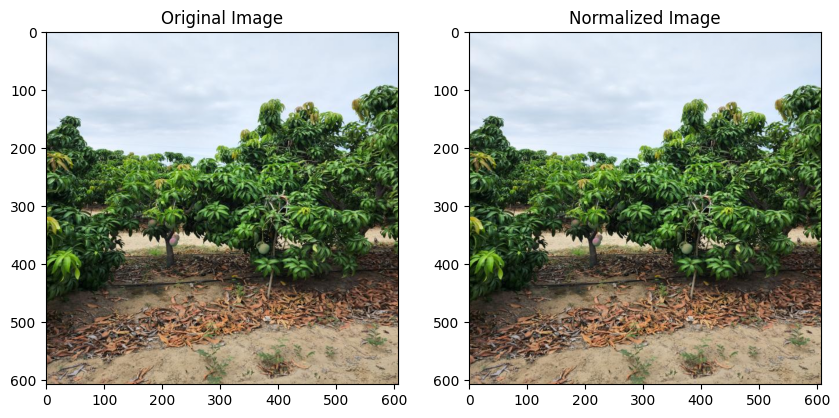

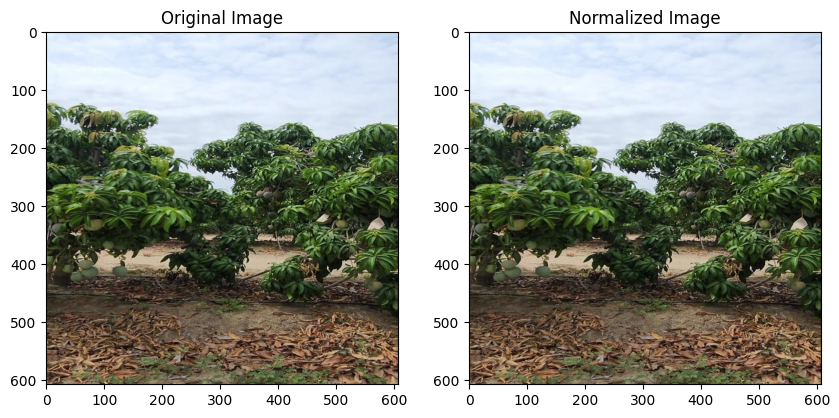

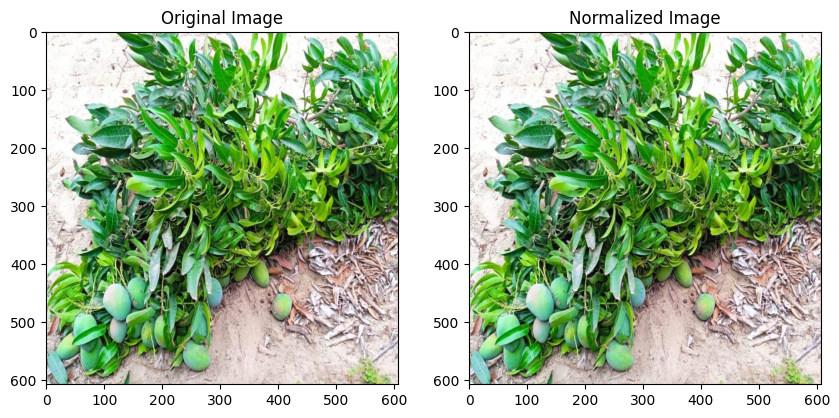

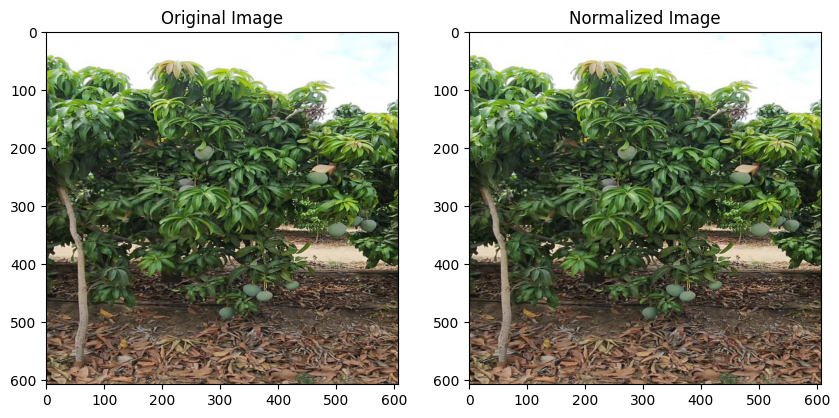

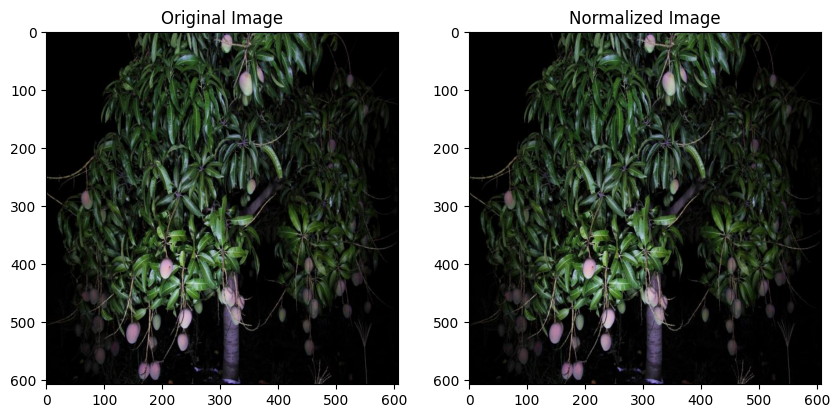

Dataset YAML configuration:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
Dataset preprocessing completed!


In [5]:
def preprocess_dataset(base_path):
    """
    Preprocess the dataset images to enhance training
    - Apply image normalization
    - Apply image augmentation
    - Check and report dataset statistics
    """
    print("Starting dataset preprocessing...")

    # Set paths
    train_path = os.path.join(base_path, 'train', 'images')
    val_path = os.path.join(base_path, 'valid', 'images')

    # Count datasets and analyze
    train_files = os.listdir(train_path)
    val_files = os.listdir(val_path)

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Sample preprocessing on a few images to test
    sample_images = train_files[:5]  # Process first 5 images as a sample

    for img_file in sample_images:
        img_path = os.path.join(train_path, img_file)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image {img_file}")
            continue

        # Convert BGR to RGB (OpenCV loads as BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize image
        img_norm = img_rgb / 255.0

        # Display original and preprocessed image for verification
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)

        plt.subplot(1, 2, 2)
        plt.title("Normalized Image")
        plt.imshow(img_norm)
        plt.show()

    # Validate dataset YAML file
    with open(os.path.join(base_path, 'data.yaml'), 'r') as f:
        yaml_content = f.read()
        print("Dataset YAML configuration:")
        print(yaml_content)

    # Create a modified YAML file for Ultralytics
    with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
        f.write(f"""
train: {train_path}
val: {val_path}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
        """)

    print("Dataset preprocessing completed!")
    return os.path.join(base_path, 'data.yaml')

# Execute preprocessing
yaml_path = preprocess_dataset('/content/mango_dataset')

# Model Training

Starting model training with YOLOv10 on device: 0...


100%|██████████| 32.1M/32.1M [00:01<00:00, 24.8MB/s]


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/content/mango_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=mango_detector_v10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 36.2MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

  8                  -1  2   1689984  ultralytics.nn.modules.block.C2fCIB          [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1   1253088  ultralytics.nn.modules.block.PSA             [576, 576]                    
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576,

100%|██████████| 5.35M/5.35M [00:00<00:00, 86.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1754.2±655.5 MB/s, size: 85.7 KB)


train: Scanning /content/mango_dataset/train/labels... 1529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1529/1529 [00:00<00:00, 1655.61it/s]

train: New cache created: /content/mango_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 539.4±442.2 MB/s, size: 66.1 KB)


val: Scanning /content/mango_dataset/valid/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 814.48it/s]

val: New cache created: /content/mango_dataset/valid/labels.cache


Plotting labels to runs/detect/mango_detector_v10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/mango_detector_v10
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.11G      3.162      2.484      1.981        288        640: 100%|██████████| 96/96 [01:07<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         65        649      0.695      0.658      0.697      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.91G      3.187      1.875      1.956        185        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         65        649      0.672      0.584      0.628       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      9.25G       3.23      1.875      1.959        368        640: 100%|██████████| 96/96 [01:04<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         65        649      0.665      0.688      0.722      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.09G      3.105      1.775       1.94        253        640: 100%|██████████| 96/96 [01:04<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         65        649      0.745       0.68      0.724      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      9.65G      3.024      1.665      1.915        239        640: 100%|██████████| 96/96 [01:04<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         65        649      0.778      0.752      0.806      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      9.49G       2.98      1.622      1.891        276        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         65        649      0.775      0.674       0.74      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       9.2G      2.977      1.599      1.901        204        640: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         65        649      0.836      0.731      0.837      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.01G      2.961      1.564      1.886        447        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         65        649       0.78      0.741      0.803      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.35G      2.904       1.54      1.874        307        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         65        649      0.838      0.741      0.833      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.06G      2.866      1.517      1.864        658        640: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         65        649      0.798      0.803      0.833      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.75G      2.836      1.452      1.848        472        640: 100%|██████████| 96/96 [01:04<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         65        649      0.831      0.768      0.837      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      9.38G      2.782      1.424      1.848        181        640: 100%|██████████| 96/96 [01:04<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         65        649      0.857       0.74      0.848      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.64G      2.799      1.455       1.86        312        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         65        649      0.817      0.777      0.836      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      9.74G       2.77      1.403       1.85        323        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         65        649      0.869      0.746      0.853       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.88G      2.753      1.385       1.84        268        640: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         65        649      0.858      0.798      0.874      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      9.37G      2.725      1.354      1.833        321        640: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         65        649      0.873       0.78      0.865      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.55G      2.731      1.347      1.832        364        640: 100%|██████████| 96/96 [01:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         65        649      0.846      0.804      0.876      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      9.52G      2.704      1.341      1.826        185        640: 100%|██████████| 96/96 [01:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         65        649      0.882      0.775      0.875       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       9.6G      2.704      1.325      1.814        359        640: 100%|██████████| 96/96 [01:04<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         65        649      0.862      0.815      0.887      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      9.13G      2.672      1.313      1.824        300        640: 100%|██████████| 96/96 [01:04<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         65        649      0.879      0.801      0.876      0.583


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.39G      2.623       1.28      1.831        284        640: 100%|██████████| 96/96 [01:04<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         65        649      0.878      0.757      0.858      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.26G      2.586      1.242      1.831        311        640: 100%|██████████| 96/96 [01:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         65        649       0.89      0.799      0.888      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.39G      2.576      1.236      1.833        192        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         65        649      0.884      0.775      0.869      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.39G       2.55      1.217      1.823        264        640: 100%|██████████| 96/96 [01:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         65        649      0.877      0.803      0.891      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.42G      2.543      1.195      1.815        146        640: 100%|██████████| 96/96 [01:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         65        649      0.853      0.832      0.891      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.31G      2.528      1.192      1.812        195        640: 100%|██████████| 96/96 [01:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         65        649      0.872      0.809      0.892      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.41G      2.483      1.148        1.8        179        640: 100%|██████████| 96/96 [01:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

                   all         65        649      0.881      0.824       0.89      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.23G      2.484      1.141      1.797        231        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         65        649      0.897      0.823      0.895      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.38G      2.463      1.123       1.79        173        640: 100%|██████████| 96/96 [01:02<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         65        649      0.874      0.832      0.897      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.41G      2.434      1.095      1.787        257        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         65        649      0.887      0.829      0.896      0.618



30 epochs completed in 0.555 hours.
Optimizer stripped from runs/detect/mango_detector_v10/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/mango_detector_v10/weights/best.pt, 33.5MB

Validating runs/detect/mango_detector_v10/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,313,747 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


                   all         65        649      0.886      0.829      0.896      0.618
Speed: 0.2ms preprocess, 13.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/mango_detector_v10
Model trained and saved to /content/mango_detector_v10.pt

Training Results:
metrics/precision(B): 0.886054433790215
metrics/recall(B): 0.8289676425269645
metrics/mAP50(B): 0.8957434133035784
metrics/mAP50-95(B): 0.6182240214871519
fitness: 0.6459759606687947


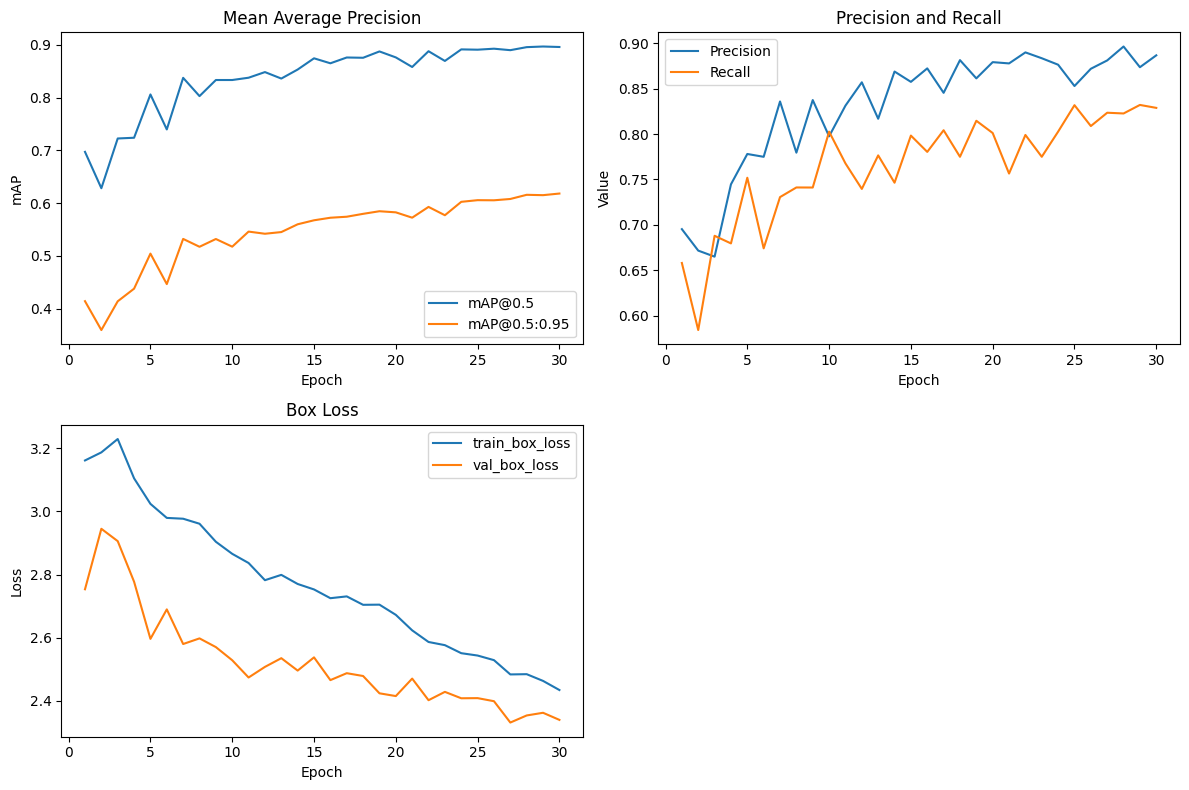

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
def train_model(dataset_yaml, epochs=50, image_size=640, batch_size=16, device=0):
    """
    Train the YOLOv10 model
    """
    print(f"Starting model training with YOLOv10 on device: {device}...")

    model = YOLO('yolov10m.pt')

    # Train the model
    results = model.train(
        data=dataset_yaml,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        name='mango_detector_v10',
        device=device,
        verbose=True
    )

    model_path = '/content/mango_detector_v10.pt'
    best_weights_path = os.path.join(model.trainer.save_dir, 'weights', 'best.pt')

    # Copy best weights to desired path
    if os.path.exists(best_weights_path):
        os.system(f"cp {best_weights_path} {model_path}")
        print(f"Model trained and saved to {model_path}")
    else:
        print(f"Best weights not found at {best_weights_path}")
        alt_path = os.path.join(model.trainer.save_dir, 'weights', 'last.pt')
        if os.path.exists(alt_path):
            os.system(f"cp {alt_path} {model_path}")
            print(f"Last checkpoint saved to {model_path}")
        else:
            print("Could not find model weights to save.")

    # Display training results
    results_dict = results.results_dict if hasattr(results, 'results_dict') else {}
    print("\nTraining Results:")
    for metric, value in results_dict.items():
        print(f"{metric}: {value}")

    # Plot training curves
    try:
        results_csv = os.path.join(model.trainer.save_dir, 'results.csv')
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)

            plt.figure(figsize=(12, 8))

            # mAP
            plt.subplot(2, 2, 1)
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            plt.title('Mean Average Precision')
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.legend()

            # Precision and Recall
            plt.subplot(2, 2, 2)
            plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
            plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
            plt.title('Precision and Recall')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()

            # Losses
            plt.subplot(2, 2, 3)
            plt.plot(df['epoch'], df['train/box_loss'], label='train_box_loss')
            plt.plot(df['epoch'], df['val/box_loss'], label='val_box_loss')
            plt.title('Box Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")

    return model, model_path

# Train the model
try:
    model, model_path = train_model(yaml_path, epochs=30, device=device)
    files.download(model_path)
except Exception as e:
    print(f"Error during training: {e}")
    model_path = '/content/runs/detect/train/weights/best.pt'
    print(f"Using fallback path: {model_path}")

# Metrics

Evaluating model metrics on device: 0...
Successfully loaded model from /content/mango_detector_v10.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,313,747 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1182.9±610.8 MB/s, size: 66.4 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


                   all         65        649       0.89      0.831      0.897      0.618
Speed: 7.7ms preprocess, 24.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val
Validation completed successfully in 8.58 seconds

===== Detection Metrics Summary =====
mAP@0.5: 0.8971
mAP@0.5:0.95: 0.6178
Precision: 0.8900
Recall: 0.8305
F1-Score: 0.8592
Time taken: 8.58 seconds


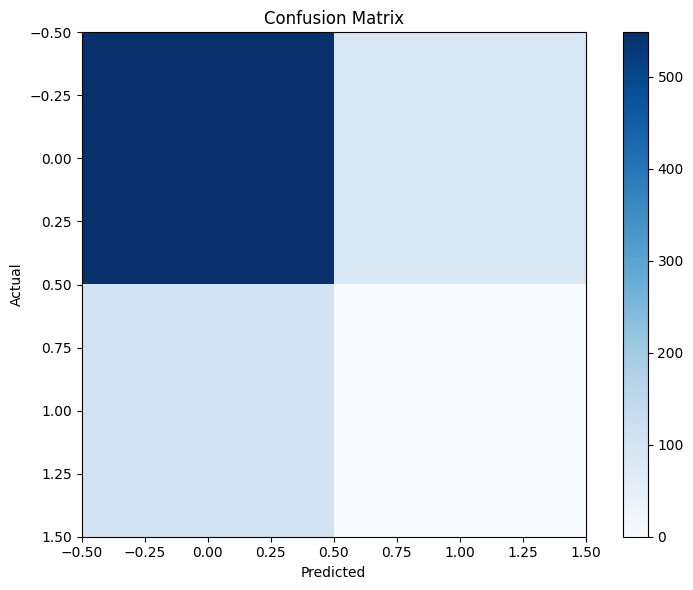


Evaluating on test set (defined in YAML)...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,313,747 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1568.2±555.9 MB/s, size: 76.2 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


                   all         65        649       0.89      0.831      0.897      0.618
Speed: 9.7ms preprocess, 22.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val2

===== Final Detection Metrics =====
Precision: 0.8900
Recall: 0.8305
F1-Score: 0.8592
mAP@0.5: 0.8971
mAP@0.5:0.95: 0.6178
mAP@0.75: 0.7259
Time taken on test set: 9.36 seconds


In [7]:
def check_model_metrics(model_path, yaml_path, device=0):
    """
    Check and visualize metrics for the trained model
    """
    print(f"Evaluating model metrics on device: {device}...")

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot evaluate metrics.")
            return None

    # Load the trained model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    # Time the validation
    try:
        start_time = time.time()
        results = model.val(data=yaml_path, device=device)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Validation completed successfully in {elapsed_time:.2f} seconds")
    except Exception as e:
        print(f"Error during validation: {e}")
        return None

    # Print metrics summary
    metrics = results.box
    print("\n===== Detection Metrics Summary =====")
    print(f"mAP@0.5: {metrics.map50:.4f}")
    print(f"mAP@0.5:0.95: {metrics.map:.4f}")
    print(f"Precision: {metrics.p[0]:.4f}")
    print(f"Recall: {metrics.r[0]:.4f}")
    print(f"F1-Score: {metrics.f1[0]:.4f}")
    print(f"Time taken: {elapsed_time:.2f} seconds")

    # Confusion matrix plot
    try:
        if hasattr(results, 'confusion_matrix') and results.confusion_matrix is not None:
            conf_matrix = results.confusion_matrix.matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

    return results

# Call the function with model and dataset paths
if 'model_path' in locals():
    model_metrics = check_model_metrics(model_path, yaml_path, device=device)

    # Display metrics on test set specifically
    print("\nEvaluating on test set (defined in YAML)...")
    try:
        model = YOLO(model_path)
        start_time = time.time()
        test_results = model.val(data=yaml_path, device=device, split='val')
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Print full metrics summary from test results
        metrics = test_results.box
        print("\n===== Final Detection Metrics =====")
        print(f"Precision: {metrics.p[0]:.4f}")
        print(f"Recall: {metrics.r[0]:.4f}")
        print(f"F1-Score: {metrics.f1[0]:.4f}")
        print(f"mAP@0.5: {metrics.map50:.4f}")
        print(f"mAP@0.5:0.95: {metrics.map:.4f}")
        print(f"mAP@0.75: {metrics.map75:.4f}")
        print(f"Time taken on test set: {elapsed_time:.2f} seconds")

    except Exception as e:
        print(f"Error evaluating on test set: {e}")
else:
    print("No model path defined. Skipping metrics check.")

# Model Inference

In [8]:
def inference_on_image(model_path, device=0):
    """
    Perform inference on uploaded images using GPU
    """
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        # Try to find the model in possible alternative locations
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]

        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot perform inference.")
            return

    print("Upload an image for inference:")
    uploaded = files.upload()  # Prompt to upload an image

    if not uploaded:
        print("No image uploaded!")
        return

    uploaded_file = list(uploaded.keys())[0]

    # Load model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Run inference with GPU
    try:
        results = model.predict(
            source=uploaded_file,
            conf=0.5,
            save=True,
            device=device
        )
        print("Inference completed successfully")
    except Exception as e:
        print(f"Error during inference: {e}")
        return

    # Display results
    for r in results:
        # Plot detection results
        boxes = r.boxes
        print(f"Found {len(boxes)} mangoes in the image")

        # Display detection details
        for box in boxes:
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            cls_name = model.names[cls]
            print(f"Detected {cls_name} with confidence {conf:.2f}")

    # Show the prediction image
    try:
        # Get the latest predict folder (sorted by creation time)
        predict_dirs = [d for d in os.listdir('runs/detect') if d.startswith('predict')]
        if predict_dirs:
            newest_dir = max(predict_dirs, key=lambda x: os.path.getctime(os.path.join('runs/detect', x)))
            result_image_path = os.path.join('runs', 'detect', newest_dir, uploaded_file)

            if os.path.exists(result_image_path):
                img = cv2.imread(result_image_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(10, 8))
                plt.title("Mango Detection Result")
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()
            else:
                print(f"Result image not found at {result_image_path}")
        else:
            print("No prediction directory found")
    except Exception as e:
        print(f"Error displaying result image: {e}")

# Run inference with the trained model
if 'model_path' in locals():
    try:
        inference_on_image(model_path, device=device)
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("No model path defined. Skipping inference.")

Upload an image for inference:


Saving WhatsApp Image 2025-04-21 at 4.26.08 PM.jpeg to WhatsApp Image 2025-04-21 at 4.26.08 PM.jpeg
Successfully loaded model from /content/mango_detector_v10.pt

image 1/1 /content/WhatsApp Image 2025-04-21 at 4.26.08 PM.jpeg: 448x640 11 Mangos, 92.1ms
Speed: 4.9ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
Inference completed successfully
Found 11 mangoes in the image
Detected Mango with confidence 0.91
Detected Mango with confidence 0.90
Detected Mango with confidence 0.89
Detected Mango with confidence 0.89
Detected Mango with confidence 0.88
Detected Mango with confidence 0.88
Detected Mango with confidence 0.86
Detected Mango with confidence 0.83
Detected Mango with confidence 0.80
Detected Mango with confidence 0.57
Detected Mango with confidence 0.53
Result image not found at runs/detect/predict/WhatsApp Image 2025-04-21 at 4.26.08 PM.jpeg
